# Proyek Klasifikasi Gambar: [dataset Cifar-10]
- **Nama:** [Ami Lia Rizki]
- **Email:** [rizkiamilia2525@gmail.com]
- **ID Dicoding:** [Amilia rizki]

Pada proyek ini, saya mencoba membangun model klasifikasi gambar menggunakan dataset CIFAR-10. Dataset ini berisi 60.000 gambar berwarna berukuran kecil (32x32 piksel) yang terbagi dalam 10 kelas, seperti pesawat, mobil, kucing, anjing, dan lainnya. CIFAR-10 sering digunakan untuk belajar dan menguji kemampuan model deep learning dalam mengenali gambar.

Tujuan Proyek

Tujuan dari proyek ini adalah untuk membuat model yang bisa mengenali gambar dan mengklasifikasikannya ke dalam kelas yang benar. Selain itu, saya juga ingin melihat seberapa akurat model yang dibuat, dan mencoba memperbaikinya jika hasilnya belum maksimal.

## Import Semua Packages/Library yang Digunakan

In [1]:
# -*- coding: utf-8 -*-
"""Modified CIFAR-10 Classification with Transfer Learning (MobileNetV2)

Proyek Klasifikasi Gambar dengan Transfer Learning: [dataset Cifar-10]
- **Nama:** [Ami Lia Rizki]
- **Email:** [rizkiamilia2525@gmail.com]
- **ID Dicoding:** [Amilia rizki]

Modifikasi: Menggunakan Transfer Learning dengan MobileNetV2 untuk meningkatkan akurasi
"""

# Install required packages
!pip install opencv-python
!pip install tensorflow

# Import essential libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.utils import to_categorical

import warnings
warnings.filterwarnings('ignore')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 MB 17.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 55.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 121.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 91.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 102.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 5.0 MB/s eta 0:00:00


In [2]:
print(tf.__version__)

2.19.0


## Data Preparation

### Data Loading

In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"amiliarizki","key":"dbc01295af2b040b126a9745bdc72c47"}'}

In [4]:
!mkdir -p ~/.kaggle  # Membuat folder .kaggle
!cp kaggle.json ~/.kaggle/  # Menyalin file kaggle.json
!chmod 600 ~/.kaggle/kaggle.json  # Memberikan izin akses
!kaggle datasets download -d ayush1220/cifar10
!unzip cifar10.zip
!ls


Streaming output truncated to the last 5000 lines.
  inflating: cifar10/train/truck/0002.png  
  inflating: cifar10/train/truck/0003.png  
  inflating: cifar10/train/truck/0004.png  
  inflating: cifar10/train/truck/0005.png  
  inflating: cifar10/train/truck/0006.png  
  inflating: cifar10/train/truck/0007.png  
  inflating: cifar10/train/truck/0008.png  
  inflating: cifar10/train/truck/0009.png  
  inflating: cifar10/train/truck/0010.png  
  inflating: cifar10/train/truck/0011.png  
  inflating: cifar10/train/truck/0012.png  
  inflating: cifar10/train/truck/0013.png  
  inflating: cifar10/train/truck/0014.png  
  inflating: cifar10/train/truck/0015.png  
  inflating: cifar10/train/truck/0016.png  
  inflating: cifar10/train/truck/0017.png  
  inflating: cifar10/train/truck/0018.png  
  inflating: cifar10/train/truck/0019.png  
  inflating: cifar10/train/truck/0020.png  
  inflating: cifar10/train/truck/0021.png  
  inflating: cifar10/train/truck/0022.png  
  inflating: cifar10/trai

In [5]:
# Check data structure
data_cifar_train = '/content/cifar10/train'
data_cifar_test = '/content/cifar10/test'
categories = os.listdir(data_cifar_train)
print("Classes:", categories)
print("Number of classes:", len(categories))

Classes: ['automobile', 'truck', 'dog', 'horse', 'ship', 'bird', 'cat', 'deer', 'airplane', 'frog']
Number of classes: 10


### Data Preprocessing

#### Split Dataset

In [6]:
def load_and_preprocess_data(data_path, img_size=(224, 224)):
    """
    Load and preprocess data for transfer learning
    - Resize to 224x224 (optimal for MobileNetV2)
    - Convert to RGB format
    """
    X = []
    y = []

    print("Loading and preprocessing data...")
    for label, category in enumerate(categories):
        category_path = os.path.join(data_path, category)
        print(f"Processing {category}...")

        for img_name in os.listdir(category_path):
            img_path = os.path.join(category_path, img_name)

            # Load image
            img = cv2.imread(img_path)
            # Convert BGR to RGB (important for transfer learning)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            # Resize to 224x224 for MobileNetV2
            img = cv2.resize(img, img_size)

            X.append(img)
            y.append(label)

    return np.array(X), np.array(y)

In [7]:
# Load data with proper preprocessing
X, y = load_and_preprocess_data(data_cifar_train)

print(f"Data shape: {X.shape}")
print(f"Labels shape: {y.shape}")

Loading and preprocessing data...
Processing automobile...
Processing truck...
Processing dog...
Processing horse...
Processing ship...
Processing bird...
Processing cat...
Processing deer...
Processing airplane...
Processing frog...
Data shape: (50000, 224, 224, 3)
Labels shape: (50000,)


In [8]:
# Split datase
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

In [9]:
print('Train Images Shape:      ', X_train.shape)
print('Validation Images Shape: ', X_valid.shape)
print('Test Images Shape:       ', X_test.shape)

Train Images Shape:       (40000, 224, 224, 3)
Validation Images Shape:  (5000, 224, 224, 3)
Test Images Shape:        (5000, 224, 224, 3)


In [10]:
# Visualize some training samples
label_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


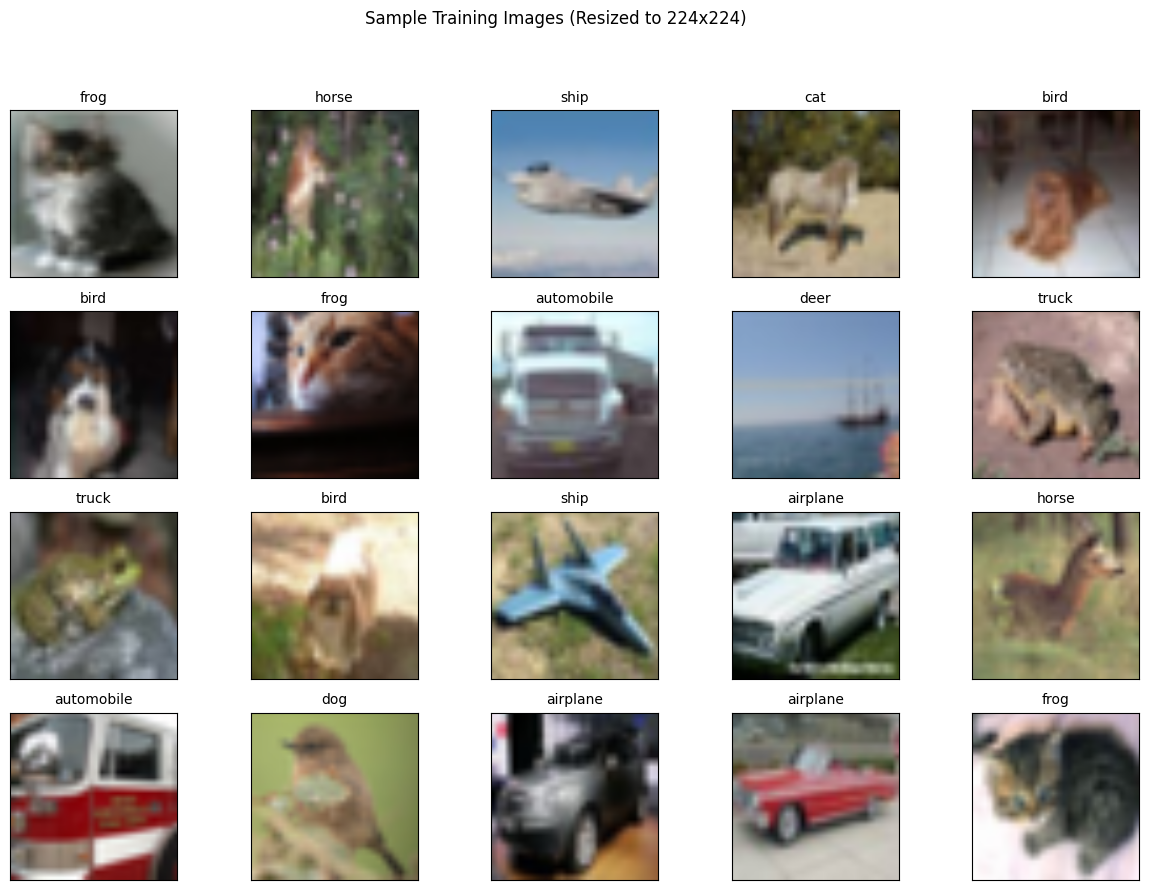

In [11]:
plt.figure(figsize=(15, 10))
for i in range(20):
    plt.subplot(4, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i])
    plt.title(label_names[y_train[i]], fontsize=10)
plt.suptitle("Sample Training Images (Resized to 224x224)")
plt.show()

In [12]:
# Convert to float32 and preprocess for MobileNetV2
X_train = X_train.astype('float32')
X_valid = X_valid.astype('float32')
X_test = X_test.astype('float32')

# Use MobileNetV2 preprocessing function
X_train = preprocess_input(X_train)
X_valid = preprocess_input(X_valid)
X_test = preprocess_input(X_test)

# Convert labels to categorical
y_train = to_categorical(y_train, 10)
y_valid = to_categorical(y_valid, 10)
y_test = to_categorical(y_test, 10)

print("Data preprocessing completed!")
print(f"Train data range: [{X_train.min():.2f}, {X_train.max():.2f}]")

Data preprocessing completed!
Train data range: [-1.00, 1.00]


In [13]:
# Data augmentation optimized for transfer learning
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.15,
    height_shift_range=0.15,
    horizontal_flip=True,
    zoom_range=0.15,
    brightness_range=[0.8, 1.2],
    shear_range=0.1,
    fill_mode='nearest'
)

In [14]:

from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models
import tensorflow as tf

def create_transfer_learning_model(num_classes=10, img_shape=(224, 224, 3)):
    """
    Create a transfer learning model using MobileNetV2.
    """
    base_model = MobileNetV2(
        input_shape=img_shape,
        include_top=False,
        weights='imagenet'
    )
    base_model.trainable = False

    model = tf.keras.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(num_classes, activation='softmax')
    ])

    return model


In [15]:
# Create the model
model = create_transfer_learning_model()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [16]:
# Display model architecture
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,054,922 (11.65 MB)

 Trainable params: 793,354 (3.03 MB)

 Non-trainable params: 2,261,568 (8.63 MB)

In [17]:
# Count trainable parameters
print(f"\nTotal parameters: {model.count_params():,}")
trainable_params = sum([tf.keras.backend.count_params(w) for w in model.trainable_weights])
print(f"Trainable parameters: {trainable_params:,}")

"""## Training Strategy: Two-Phase Fine-tuning

### Phase 1: Train only the classifier head
"""

# Phase 1: Compile with higher learning rate for new layers
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


Total parameters: 3,054,922
Trainable parameters: 793,354


In [18]:
# Callbacks for Phase 1
callbacks_phase1 = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7, verbose=1),
    ModelCheckpoint('best_model_phase1.h5', monitor='val_accuracy', save_best_only=True, verbose=1)
]

print("=== PHASE 1: Training classifier head only ===")

=== PHASE 1: Training classifier head only ===


In [19]:
# Train Phase 1
batch_size = 64
epochs_phase1 = 5

history_phase1 = model.fit(
    train_datagen.flow(X_train, y_train, batch_size=batch_size),
    steps_per_epoch=len(X_train) // batch_size,
    epochs=epochs_phase1,
    validation_data=(X_valid, y_valid),
    callbacks=callbacks_phase1,
    verbose=1
)

"""### Phase 2: Fine-tune some layers of the base model"""

# Phase 2: Unfreeze some layers of the base model for fine-tuning
base_model = model.layers[0]

# Unfreeze the last 30 layers of MobileNetV2
base_model.trainable = True
fine_tune_at = len(base_model.layers) - 30

# Freeze all layers before fine_tune_at
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

print(f"=== PHASE 2: Fine-tuning last {len(base_model.layers) - fine_tune_at} layers ===")

# Recompile with lower learning rate for fine-tuning
model.compile(
    optimizer=Adam(learning_rate=0.0001),  # Lower learning rate for fine-tuning
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Count trainable parameters after unfreezing
trainable_params = sum([tf.keras.backend.count_params(w) for w in model.trainable_weights])
print(f"Trainable parameters after unfreezing: {trainable_params:,}")

# Callbacks for Phase 2
callbacks_phase2 = [
    EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=7, min_lr=1e-8, verbose=1),
    ModelCheckpoint('best_model_phase2.h5', monitor='val_accuracy', save_best_only=True, verbose=1)
]

# Train Phase 2
epochs_phase2 = 10

history_phase2 = model.fit(
    train_datagen.flow(X_train, y_train, batch_size=batch_size),
    steps_per_epoch=len(X_train) // batch_size,
    epochs=epochs_phase2,
    validation_data=(X_valid, y_valid),
    callbacks=callbacks_phase2,
    verbose=1,
    initial_epoch=len(history_phase1.history['loss'])  # Continue from Phase 1
)

"""## Evaluation and Visualization"""

# Combine training histories
def combine_histories(hist1, hist2):
    """Combine two training histories"""
    combined = {}
    for key in hist1.history.keys():
        combined[key] = hist1.history[key] + hist2.history[key]
    return combined

combined_history = combine_histories(history_phase1, history_phase2)


Epoch 1/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 894ms/step - accuracy: 0.6021 - loss: 1.2806
Epoch 1: val_accuracy improved from -inf to 0.82780, saving model to best_model_phase1.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 602s 954ms/step - accuracy: 0.6022 - loss: 1.2801 - val_accuracy: 0.8278 - val_loss: 0.4998 - learning_rate: 0.0010
Epoch 2/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 897ms/step - accuracy: 0.7375 - loss: 0.7696
Epoch 2: val_accuracy improved from 0.82780 to 0.84400, saving model to best_model_phase1.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 592s 947ms/step - accuracy: 0.7375 - loss: 0.7696 - val_accuracy: 0.8440 - val_loss: 0.4621 - learning_rate: 0.0010
Epoch 3/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 894ms/step - accuracy: 0.7569 - loss: 0.7058
Epoch 3: val_accuracy improved from 0.84400 to 0.84440, saving model to best_model_phase1.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 590s 944ms/step - accuracy: 0.7568 - loss: 0.7058 - val_accuracy: 0.8444 - val_loss: 0.4450 - learning_rate: 0.0010
Epoch 4/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 893ms/step - accuracy: 0.7611 - loss: 0.6815
Epoch 4: val_accuracy improved from 0.84440 to 0.85280, saving model to best_model_phase1.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 590s 943ms/step - accuracy: 0.7611 - loss: 0.6815 - val_accuracy: 0.8528 - val_loss: 0.4289 - learning_rate: 0.0010
Epoch 5/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 894ms/step - accuracy: 0.7679 - loss: 0.6724
Epoch 5: val_accuracy did not improve from 0.85280
625/625 ━━━━━━━━━━━━━━━━━━━━ 590s 944ms/step - accuracy: 0.7679 - loss: 0.6724 - val_accuracy: 0.8370 - val_loss: 0.4549 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 4.
=== PHASE 2: Fine-tuning last 30 layers ===
Trainable parameters after unfreezing: 2,319,754
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 946ms/step - accuracy: 0.7717 - loss: 0.6618
Epoch 6: val_accuracy improved from -inf to 0.85760, saving model to best_model_phase2.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 640s 1s/step - accuracy: 0.7718 - loss: 0.6617 - val_accuracy: 0.8576 - val_loss: 0.4328 - learning_rate: 1.0000e-04
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 947ms/step - accuracy: 0.8514 - loss: 0.4442
Epoch 7: val_accuracy did not improve from 0.85760
625/625 ━━━━━━━━━━━━━━━━━━━━ 624s 998ms/step - accuracy: 0.8514 - loss: 0.4442 - val_accuracy: 0.8488 - val_loss: 0.4604 - learning_rate: 1.0000e-04
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 946ms/step - accuracy: 0.8684 - loss: 0.3828
Epoch 8: val_accuracy improved from 0.85760 to 0.89720, saving model to best_model_phase2.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 624s 997ms/step - accuracy: 0.8684 - loss: 0.3828 - val_accuracy: 0.8972 - val_loss: 0.2962 - learning_rate: 1.0000e-04
Epoch 9/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 946ms/step - accuracy: 0.8850 - loss: 0.3370
Epoch 9: val_accuracy improved from 0.89720 to 0.90280, saving model to best_model_phase2.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 624s 998ms/step - accuracy: 0.8850 - loss: 0.3370 - val_accuracy: 0.9028 - val_loss: 0.2899 - learning_rate: 1.0000e-04
Epoch 10/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 947ms/step - accuracy: 0.9008 - loss: 0.2956
Epoch 10: val_accuracy improved from 0.90280 to 0.90820, saving model to best_model_phase2.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 624s 998ms/step - accuracy: 0.9008 - loss: 0.2956 - val_accuracy: 0.9082 - val_loss: 0.2838 - learning_rate: 1.0000e-04
Restoring model weights from the end of the best epoch: 10.


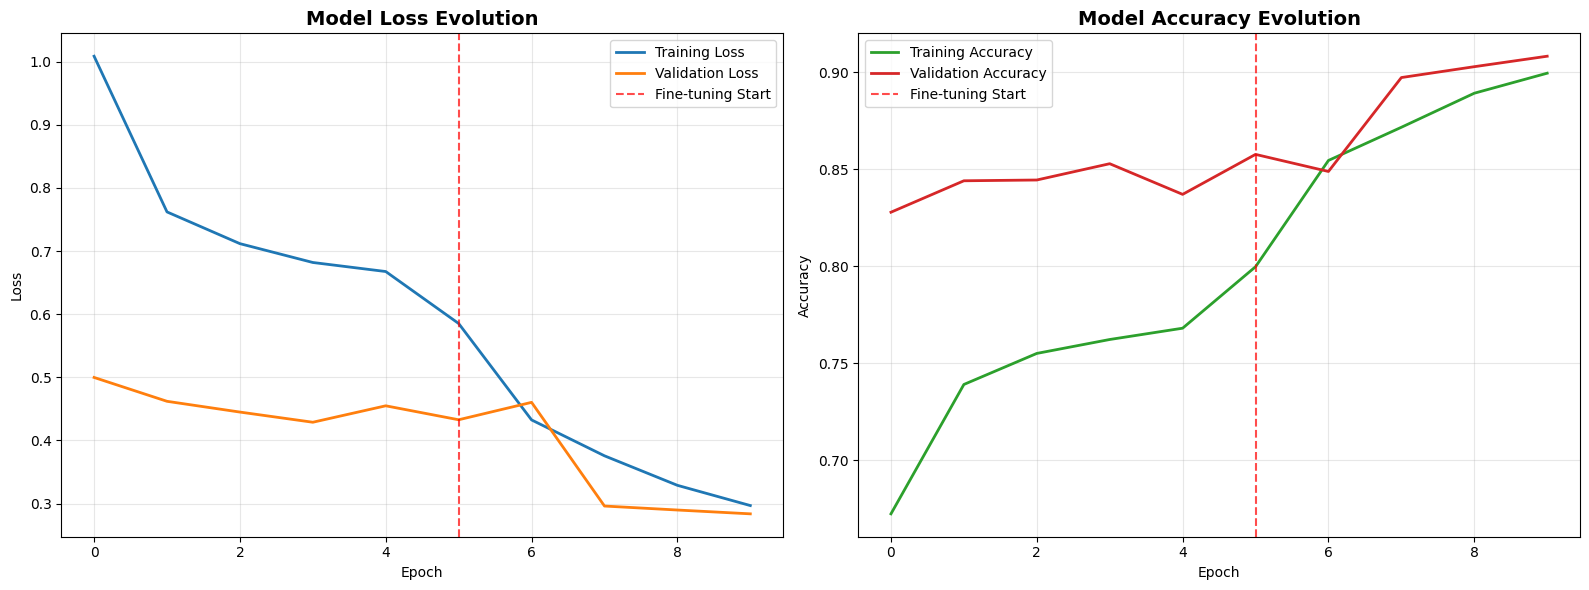

In [20]:
# Plot training history
plt.figure(figsize=(16, 6))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(combined_history['loss'], label='Training Loss', color='#1f77b4', linewidth=2)
plt.plot(combined_history['val_loss'], label='Validation Loss', color='#ff7f0e', linewidth=2)
plt.axvline(x=len(history_phase1.history['loss']), color='red', linestyle='--', alpha=0.7, label='Fine-tuning Start')
plt.title('Model Loss Evolution', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(combined_history['accuracy'], label='Training Accuracy', color='#2ca02c', linewidth=2)
plt.plot(combined_history['val_accuracy'], label='Validation Accuracy', color='#d62728', linewidth=2)
plt.axvline(x=len(history_phase1.history['loss']), color='red', linestyle='--', alpha=0.7, label='Fine-tuning Start')
plt.title('Model Accuracy Evolution', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [21]:
# Evaluate on test set
print("=== FINAL MODEL EVALUATION ===")
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)

print(f'\nTest Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)')
print(f'Test Loss: {test_loss:.4f}')

# Predictions
y_pred_probs = model.predict(X_test, verbose=1)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)
# Detailed classification report
print("\n=== CLASSIFICATION REPORT ===")
print(classification_report(y_true, y_pred, target_names=label_names, digits=4))

=== FINAL MODEL EVALUATION ===
157/157 ━━━━━━━━━━━━━━━━━━━━ 32s 200ms/step - accuracy: 0.8963 - loss: 0.3056

Test Accuracy: 0.9034 (90.34%)
Test Loss: 0.2816
157/157 ━━━━━━━━━━━━━━━━━━━━ 34s 210ms/step

=== CLASSIFICATION REPORT ===
              precision    recall  f1-score   support

    airplane     0.9748    0.9280    0.9508       500
  automobile     0.9476    0.9760    0.9616       500
        bird     0.7910    0.8780    0.8322       500
         cat     0.9006    0.9420    0.9208       500
        deer     0.9520    0.9520    0.9520       500
         dog     0.8402    0.9360    0.8855       500
        frog     0.8759    0.7480    0.8069       500
       horse     0.8884    0.8920    0.8902       500
        ship     0.9130    0.9660    0.9388       500
       truck     0.9808    0.8160    0.8908       500

    accuracy                         0.9034      5000
   macro avg     0.9064    0.9034    0.9030      5000
weighted avg     0.9064    0.9034    0.9030      5000



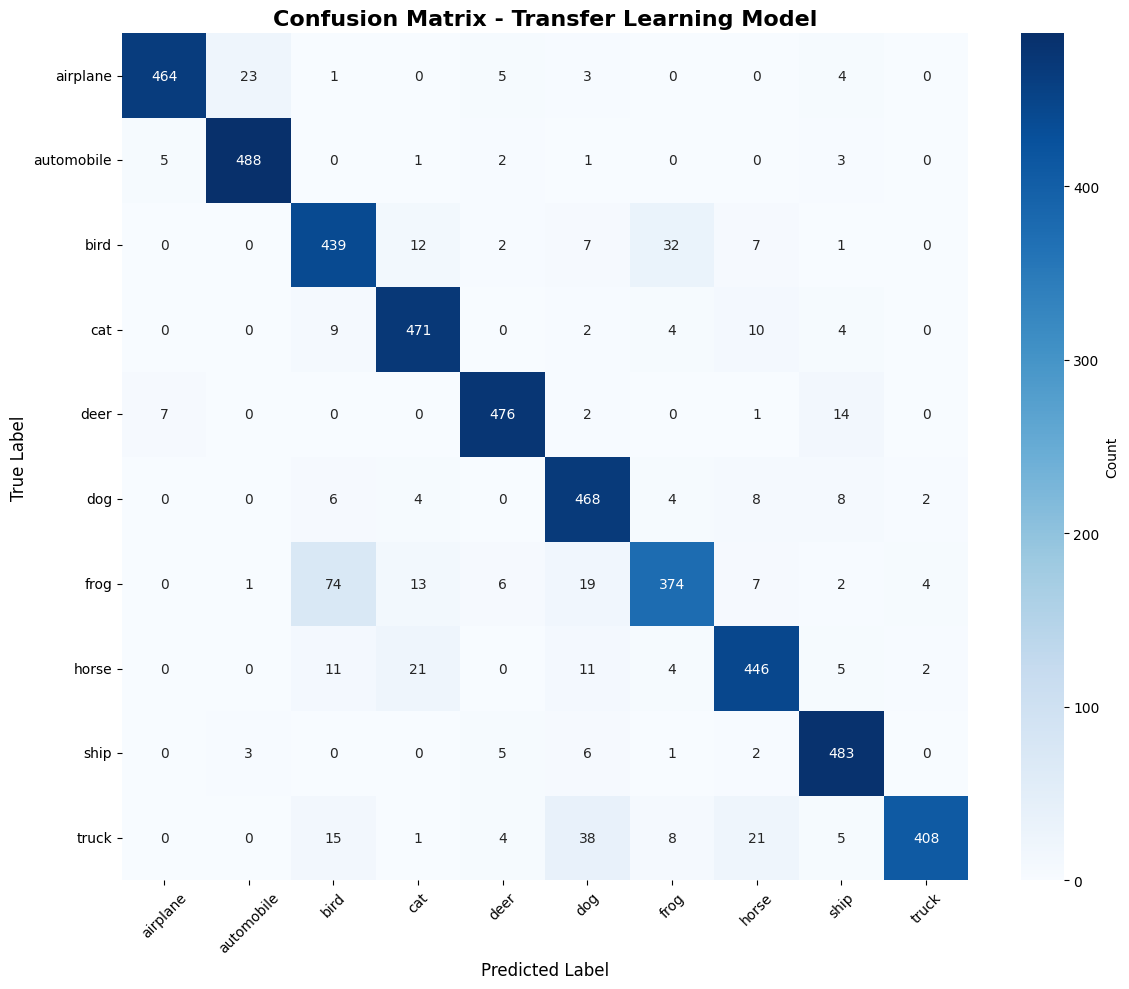

In [22]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
cm_df = pd.DataFrame(cm, index=label_names, columns=label_names)

plt.figure(figsize=(12, 10))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - Transfer Learning Model', fontsize=16, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [23]:
# Per-class accuracy
class_accuracy = cm.diagonal() / cm.sum(axis=1)
class_acc_df = pd.DataFrame({
    'Class': label_names,
    'Accuracy': class_accuracy,
    'Accuracy (%)': class_accuracy * 100
}).sort_values('Accuracy', ascending=False)

print("\n=== PER-CLASS ACCURACY ===")
print(class_acc_df.to_string(index=False))



=== PER-CLASS ACCURACY ===
     Class  Accuracy  Accuracy (%)
automobile     0.976          97.6
      ship     0.966          96.6
      deer     0.952          95.2
       cat     0.942          94.2
       dog     0.936          93.6
  airplane     0.928          92.8
     horse     0.892          89.2
      bird     0.878          87.8
     truck     0.816          81.6
      frog     0.748          74.8


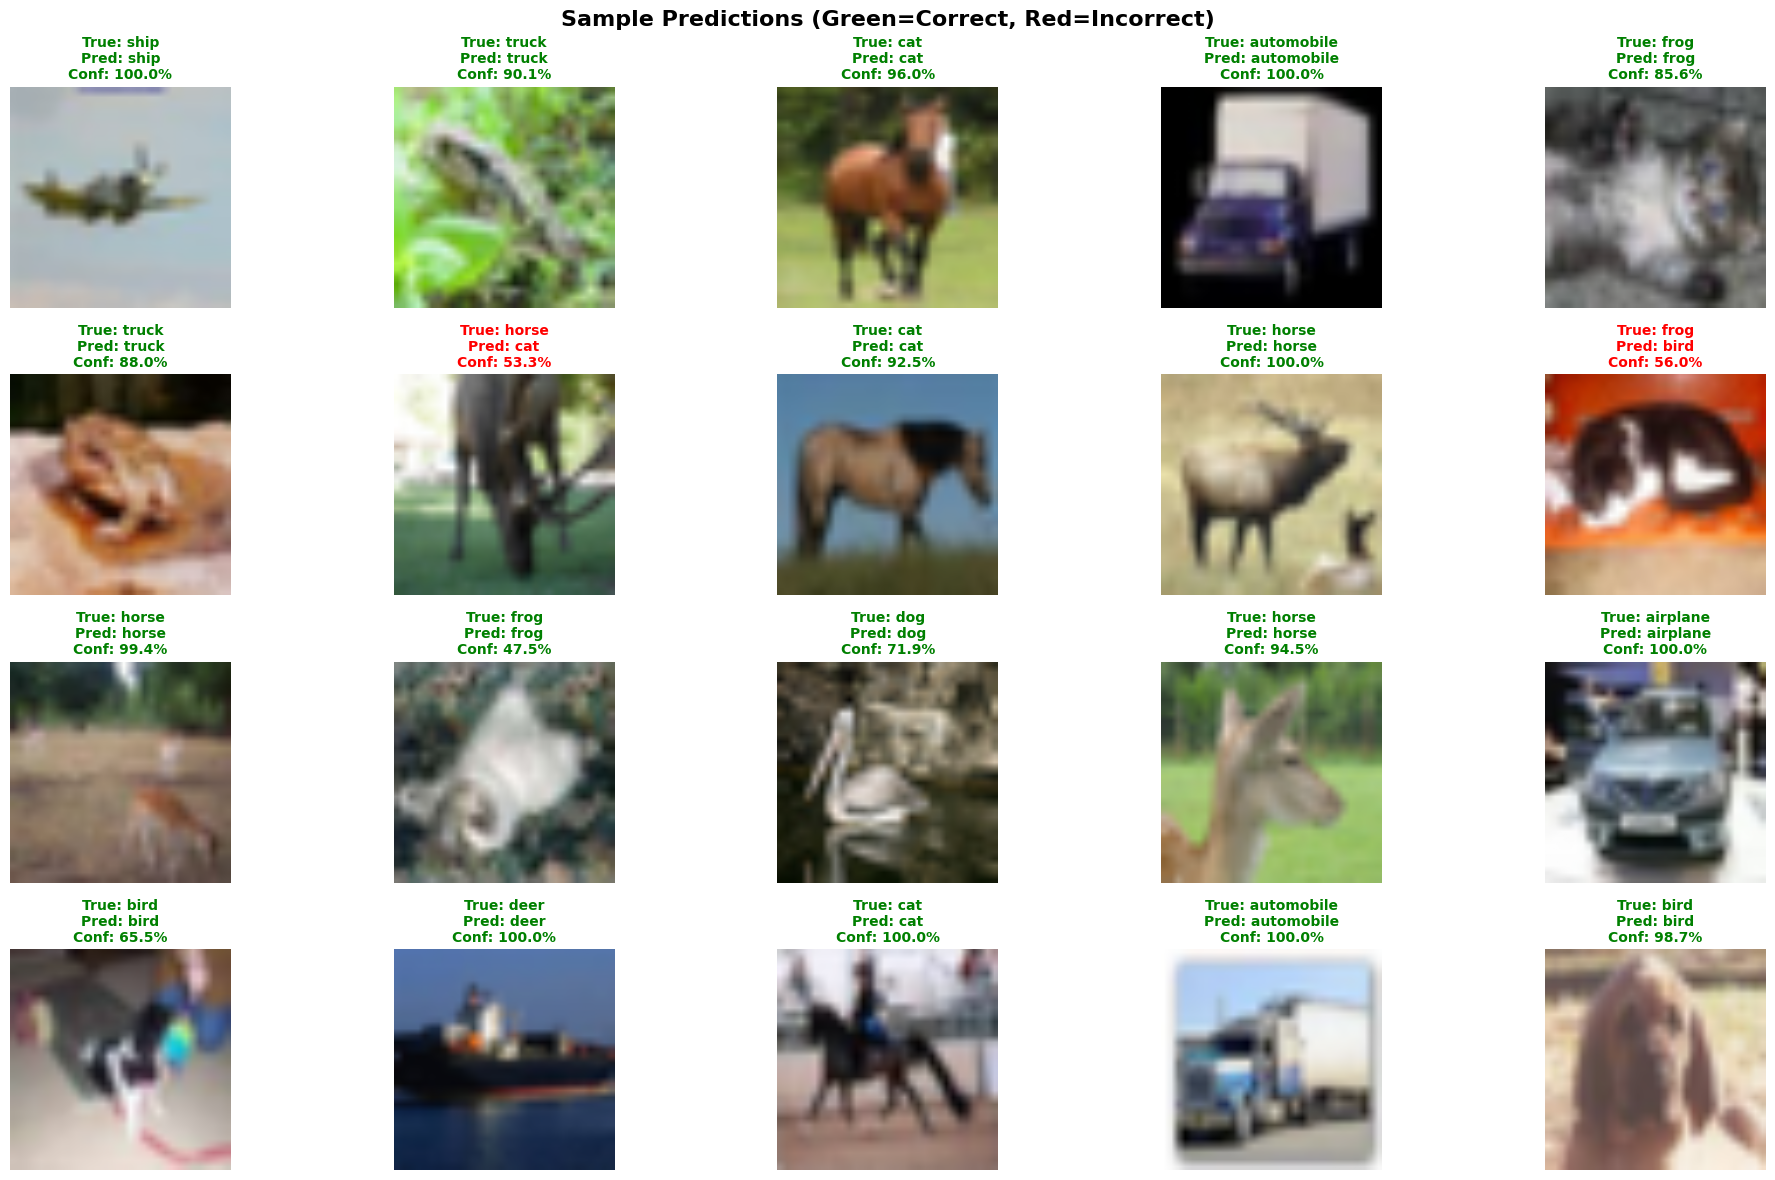

In [24]:
# Visualize some predictions
def plot_predictions(images, true_labels, pred_labels, pred_probs, class_names, num_samples=20):
    """Plot sample predictions"""
    plt.figure(figsize=(20, 12))

    for i in range(min(num_samples, len(images))):
        plt.subplot(4, 5, i+1)

        # Denormalize image for display
        img = images[i].copy()
        img = (img + 1.0) / 2.0  # Approximate denormalization for MobileNetV2
        img = np.clip(img, 0, 1)

        plt.imshow(img)
        plt.axis('off')

        true_class = class_names[true_labels[i]]
        pred_class = class_names[pred_labels[i]]
        confidence = pred_probs[i][pred_labels[i]] * 100

        color = 'green' if true_labels[i] == pred_labels[i] else 'red'
        plt.title(f'True: {true_class}\nPred: {pred_class}\nConf: {confidence:.1f}%',
                 color=color, fontsize=10, fontweight='bold')

    plt.suptitle('Sample Predictions (Green=Correct, Red=Incorrect)', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Show sample predictions
plot_predictions(X_test, y_true, y_pred, y_pred_probs, label_names)

In [25]:
# Save the final model
model.save('cifar10_transfer_learning_model.h5')
print("Model saved as 'cifar10_transfer_learning_model.h5'")

# Export to SavedModel format
model.export("saved_model/cifar10_transfer_model")
print("Model exported to SavedModel format")

# Create labels file
os.makedirs("tflite", exist_ok=True)
with open("tflite/labels.txt", "w") as f:
    f.write('\n'.join(label_names))

# Convert to TFLite
converter = tf.lite.TFLiteConverter.from_saved_model("saved_model/cifar10_transfer_model")
# Optional: Optimize for size and latency
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

# Save TFLite model
with open("tflite/cifar10_transfer_model.tflite", "wb") as f:
    f.write(tflite_model)

print("TFLite model saved")

# Convert to TensorFlow.js (optional)
!pip install tensorflowjs
!tensorflowjs_converter --input_format=tf_saved_model saved_model/cifar10_transfer_model tfjs_model

# Download files
from google.colab import files

files.download('tflite/cifar10_transfer_model.tflite')
files.download('tflite/labels.txt')
files.download('cifar10_transfer_learning_model.h5')

print("\n=== TRAINING COMPLETE ===")
print(f"Final Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print("Files ready for download!")

# Generate requirements.txt
!pip freeze > requirements.txt
files.download('requirements.txt')

Model saved as 'cifar10_transfer_learning_model.h5'
Saved artifact at 'saved_model/cifar10_transfer_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_154')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  138556281697296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138556281698448: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138556281698832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138556281698064: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138556281697104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138556281698640: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138556281698256: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138556281695952: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138556281699408: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138556281

2025-06-13 04:00:02.883935: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749787202.905285   31106 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749787202.911433   31106 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1749787202.930251   31106 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1749787202.930275   31106 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1749787202.930278   31106 computation_placer.cc:177] computation placer alr

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


=== TRAINING COMPLETE ===
Final Test Accuracy: 0.9034 (90.34%)
Files ready for download!


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>